In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
from torch.utils.data.dataset import Dataset

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os,sys
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
torch.cuda.is_available()

PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


True

In [3]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class, in_channels,dropout=0.2):
        super().__init__()
                
        self.dconv_down1 = double_conv(in_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down5 = double_conv(512, 1024)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up4 = double_conv(512 + 1024, 512)
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, in_channels, 1)
        self.fc1 = nn.Linear(25600 ,1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(dropout)
        self.out = nn.Linear(1024, n_class)
        self.relu = nn.ReLU()
#         self.init_weights()
        
#     def init_weights(self):
#         self.dconv_down1.weight.data.normal_(0, 0.01)
#         self.dconv_down2.weight.data.normal_(0, 0.01)
#         self.dconv_down3.weight.data.normal_(0, 0.01)
#         self.dconv_down4.weight.data.normal_(0, 0.01)
#         self.dconv_up3.weight.data.normal_(0, 0.01)
#         self.dconv_up2.weight.data.normal_(0, 0.01)
#         self.dconv_up1.weight.data.normal_(0, 0.01)
#         self.conv_last.weight.data.normal_(0, 0.01)
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4) 
    
        x = self.dconv_down5(x) 
        
        #Classifier
        flatten = x.view(x.size(0),-1)
#         print('fc:',flatten.size())
        y = self.fc1(flatten)
        y = self.bn_fc1(y)
        y = self.relu(y)
        y = self.dropout1(y)

        y = self.out(y)
#         print('out:',x.size())
        prediction = nn.functional.log_softmax(y,dim=1)
        
        x = self.upsample(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)
        
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)
        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        out = self.relu(out)
        return out,prediction

In [4]:
def init_weights(m):
# print(m)
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        m.weight.data.normal_(0, 0.0001)
# print(m.weight)

# net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
# net.apply(init_weights)

In [5]:
from collections import defaultdict
import torch.nn.functional as F

In [6]:
def calc_loss(out, prediction, target, original, metrics, MSE_weight=0.5):
    CE = F.cross_entropy(prediction, target)
#     BCE = F.binary_cross_entropy_with_logits(prediction, target)
#     out = torch.sigmoid(out)
    MSE = F.mse_loss(out*65535, original*65535)
    
    loss = MSE * MSE_weight + CE * (1 - MSE_weight)
#     loss = MSE * MSE_weight + CE
    
    metrics['CE'] += CE.data.cpu().numpy() * target.size(0)
    metrics['MSE'] += MSE.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))   

In [7]:
def train_model(model, dataloaders, optimizer1, optimizer2, scheduler1, scheduler2, num_epochs=25):
    start = datetime.now()
    val_acc_history = []
    train_acc_history = []
    val_Bacc_history = []
    train_Bacc_history = []
    val_loss_history = []
    train_loss_history = []
    val_MSEloss_history = []
    lr_history = []
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if epoch < 5:
                    for param_group in optimizer1.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                else:
                    for param_group in optimizer2.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
#             running_loss = 0.0
            running_corrects = 0
            confusion_matrix = torch.zeros(3, 3)
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                if epoch < 5:
                    optimizer1.zero_grad()
                else:
                    optimizer2.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs,predictions = model(inputs)
                    loss = calc_loss(outputs, predictions,labels,inputs, metrics,MSE_weight = 1e-8)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        if epoch < 5:
                            optimizer1.step()
                        else:
                            optimizer2.step()
                _, preds = torch.max(predictions, 1)
                # statistics
                epoch_samples += inputs.size(0)
                # statistics
                for t, p in zip(labels.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
                  
                running_corrects += torch.sum(preds == labels.data)
            
            
            confusionMat = np.asarray(confusion_matrix)
            sumconfusion = np.sum(confusionMat,axis = 1).T

            summat = np.tile(sumconfusion,(3,1)).T
            # print(test)
            percentconfusion = np.divide(confusionMat,summat)
            epoch_acc_balanced = np.sum(np.diagonal(percentconfusion))/3
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            epoch_acc = running_corrects.double() / epoch_samples
            print('{} Acc: {:.4f}'.format(phase, epoch_acc))
            print('{} Bal. Acc: {:.4f}'.format(phase, epoch_acc_balanced))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print("saving best model")
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_Bacc_history.append(epoch_acc_balanced)
                val_loss_history.append(epoch_loss)
                val_MSEloss_history.append(metrics['MSE']/epoch_samples)
                if epoch < 5:
                    scheduler1.step(epoch_loss)
                elif epoch > num_epochs * (2/3):
                    scheduler2.step(epoch_loss)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_Bacc_history.append(epoch_acc_balanced)
                train_loss_history.append(epoch_loss)
#             if epoch_acc == 1:
#                 break
        
        if epoch > 2 and val_MSEloss_history[-1] > 1.2e7 :
                break
        print("Total time: %s" %(datetime.now() - start))
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_acc_history,train_loss_history,val_acc_history,val_loss_history,lr_history,train_Bacc_history,val_Bacc_history

In [8]:
DatadirTrain = "F:\\WBCDataset_v4\\2DProjectionsKFold-aug"
DatadirVal = "F:\\WBCDataset_v4\\2DProjectionsKFold-aug"

In [9]:
# import os
# import os.path

# for dirpath, dirnames, filenames in os.walk("."):
#     for filename in [f for f in filenames if f.endswith(".log")]:
#         print os.path.join(dirpath, filename)
FoldName = ["Fold-1","Fold-2","Fold-3","Fold-4","Fold-5"]
tempName =FoldName
ValFold = tempName.pop(1)
# FoldName = tempName
print(FoldName)
print(ValFold)
for name in FoldName:
    print(name)

['Fold-1', 'Fold-3', 'Fold-4', 'Fold-5']
Fold-2
Fold-1
Fold-3
Fold-4
Fold-5


In [10]:
import os

def datapreparation(DatadirTrain,DatadirVal,Fold):
    trainpath = []
    FoldName = ["Fold-1","Fold-2","Fold-3","Fold-4","Fold-5"]
    ValFold = FoldName.pop(Fold)
    
    fpath = []
    traindir = DatadirTrain + "\\Gra_Y"
    for name in FoldName:
        trainsubdir = traindir + "\\" + name
        for dirpath, dirnames, filenames in os.walk(trainsubdir):
            for filename in [f for f in filenames if f.endswith(".tif")]:
                tempfpath =os.path.join(dirpath, filename)
                fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Gra train data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])

    fpath = []
    traindir = DatadirTrain + "\\Lym_G"
    for name in FoldName:
        trainsubdir = traindir + "\\" + name
        for dirpath, dirnames, filenames in os.walk(trainsubdir):
            for filename in [f for f in filenames if f.endswith(".tif")]:
                tempfpath =os.path.join(dirpath, filename)
                fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Lym train data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])

    fpath = []
    traindir = DatadirTrain + "\\Mon_U"
    for name in FoldName:
        trainsubdir = traindir + "\\" + name
        for dirpath, dirnames, filenames in os.walk(trainsubdir):
            for filename in [f for f in filenames if f.endswith(".tif")]:
                tempfpath =os.path.join(dirpath, filename)
                fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Mon train data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])

    minitrainpath = []
    minivalpath = []
    valpath = []
    
    fpath = []
    traindir = DatadirVal + "\\Gra_Y"+"\\"+ ValFold
    print(traindir)
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Gra Val data: %d' %(len(train)))
    for i in train:
        valpath.append(fpath[i])
    minitrain, minival = train_test_split(train, test_size=0.2, random_state=3)
    print('Gra mini-train data: %d' %(len(minitrain)))
    print('Gra mini-val data: %d' %(len(minival)))
    for i in minitrain:
        minitrainpath.append(fpath[i])
    for i in minival:
        minivalpath.append(fpath[i])

    fpath = []
    traindir = DatadirVal + "\\Lym_G"+"\\"+ ValFold
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Lym Val data: %d' %(len(train)))
    for i in train:
        valpath.append(fpath[i]) 
    minitrain, minival = train_test_split(train, test_size=0.2, random_state=3)
    print('Lym mini-train data: %d' %(len(minitrain)))
    print('Lym mini-val data: %d' %(len(minival)))
    for i in minitrain:
        minitrainpath.append(fpath[i])
    for i in minival:
        minivalpath.append(fpath[i])

    fpath = []
    traindir = DatadirVal + "\\Mon_U"+"\\"+ ValFold
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Mon Val data: %d' %(len(train)))
    for i in train:
        valpath.append(fpath[i])
    minitrain, minival = train_test_split(train, test_size=0.2, random_state=3)
    print('Mon mini-train data: %d' %(len(minitrain)))
    print('Mon mini-val data: %d' %(len(minival)))
    for i in minitrain:
        minitrainpath.append(fpath[i])
    for i in minival:
        minivalpath.append(fpath[i])
    return trainpath,valpath,minitrainpath,minivalpath

In [11]:
Fold = 0
trainpath,testpath,_,_= datapreparation(DatadirTrain,DatadirVal,Fold)

Gra train data: 10870
Lym train data: 9795
Mon train data: 12153
F:\WBCDataset_v4\2DProjectionsKFold-aug\Gra_Y\Fold-1
Gra Val data: 2720
Gra mini-train data: 2176
Gra mini-val data: 544
Lym Val data: 2447
Lym mini-train data: 1957
Lym mini-val data: 490
Mon Val data: 3037
Mon mini-train data: 2429
Mon mini-val data: 608


In [12]:
print('train data vol.: ',len(trainpath))
print('test data vol.: ',len(testpath))

train data vol.:  32818
test data vol.:  8204


In [13]:
from skimage import io
import skimage.transform
import scipy
class MyDataset(Dataset):
    def __init__(self, mat_paths, transforms=None):
        self.paths = mat_paths
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Load .mat
#         data = loadmat(self.paths[index])
        data = io.imread(self.paths[index])
#         reshape = skimage.transform.resize(data,(224,224,40))
#         x = torch.from_numpy(reshape.astype(np.float32))
        x = torch.from_numpy(data.astype(np.float32)/65535)
        x = x.unsqueeze(dim = 0)
#         x = np.transpose(x,(2,0,1))
#         x = np.transpose(np.array(data['Data']),(2,0,1))
        if 'Gra' in self.paths[index]:
            label = int(0)
        elif 'Lym' in self.paths[index]:
            label = int(1)
        elif 'Mon' in self.paths[index]:
            label = int(2)
        if self.transforms:
            x= self.transforms(x)
        return x,label
    
    def __len__(self):
        return len(self.paths)

In [14]:
#actual training
image_datasets = {}
mini_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
# mini_datasets['train'] = MyDataset(minitrainpath)
# mini_datasets['val'] = MyDataset(minivalpath)
# model testing
# image_datasets['train'] = MyDataset(valpath)
# image_datasets['val'] = MyDataset(testpath)
# test_datasets['val'] = MyDataset(testpath)
print('training data volume: ', image_datasets['train'].__len__())
print('validation data volume: ', image_datasets['val'].__len__())

# print('mini-training data volume: ', mini_datasets['train'].__len__())
# print('mini-validation data volume: ', mini_datasets['val'].__len__())

CellName = ['Granulocyte','Lymphocyte','Monocyte']
image_datasets['train'].__getitem__(0)[0].shape
[ImgTensor,ImgLabel] = image_datasets['train'].__getitem__(0)
print('Cell Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
image_datasets['train'].__getitem__(0)[0]

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)

training data volume:  32818
validation data volume:  8204
Cell Label:  Granulocyte
image tensor shape:  torch.Size([1, 80, 80])
image tensor dtype:  torch.float32
image shape:  (80, 80)


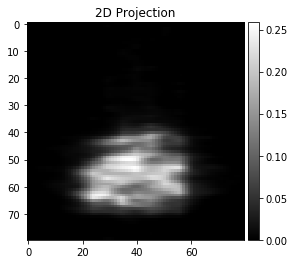

In [15]:
#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.transpose(ImgTensor.numpy(), (1,2,0))

def DisplayImage(img,LimMin,LimMax):  
    if img.shape[2]>1:
        for depth in range (0,10):
            plt.subplot(2,5,depth+1)
            plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')
            # plt.colorbar()
            plt.title('z = '+ str(depth))
            if depth==9:
                plt.subplot(2,5,depth+1)
                plt.title('z = '+ str(depth))
                ax = plt.gca()
                fig4 = plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()
    else:
        fig4 = plt.imshow(np.squeeze(img),vmin=LimMin, vmax=LimMax, cmap ='gray')
        plt.title('2D Projection')
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()
DisplayImage(image,image.min(),image.max())

In [16]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 64
# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Fold- 0 : Initializing Datasets and Dataloaders...
Gra train data: 10870
Lym train data: 9795
Mon train data: 12153
F:\WBCDataset_v4\2DProjectionsKFold-aug\Gra_Y\Fold-1
Gra Val data: 2720
Gra mini-train data: 2176
Gra mini-val data: 544
Lym Val data: 2447
Lym mini-train data: 1957
Lym mini-val data: 490
Mon Val data: 3037
Mon mini-train data: 2429
Mon mini-val data: 608
Epoch 0/99
----------
LR 5e-05
train: CE: 1.096951, MSE: 12685412.056981, loss: 1.223805
train Acc: 0.3574
train Bal. Acc: 0.3331
val: CE: 1.094732, MSE: 12651040.518771, loss: 1.221243
val Acc: 0.3702
val Bal. Acc: 0.3333
saving best model
Total time: 0:05:23.613060
Epoch time: 5m 24s
Epoch 1/99
----------
LR 5e-05
train: CE: 1.094827, MSE: 12685411.998355, loss: 1.221682
train Acc: 0.3703
train Bal. Acc: 0.3333
val: CE: 1.095605, MSE: 12651040.501706, loss: 1.222116
val Acc: 0.3702
val Bal. Acc: 0.3333
Total time: 0:10:47.148331
Epoch time: 5m 24s
Epoch 2/99
----------
LR 5e-05
train: CE: 1.094810, MSE: 12685412.07252

train Bal. Acc: 0.8270
val: CE: 0.755744, MSE: 167437.811373, loss: 0.757418
val Acc: 0.7583
val Bal. Acc: 0.7413
Total time: 1:21:57.683037
Epoch time: 5m 29s
Epoch 15/99
----------
LR 5e-05
train: CE: 0.421017, MSE: 160569.225570, loss: 0.422623
train Acc: 0.8302
train Bal. Acc: 0.8295
val: CE: 0.492214, MSE: 163499.174412, loss: 0.493849
val Acc: 0.8251
val Bal. Acc: 0.8215
saving best model
Total time: 1:27:26.105229
Epoch time: 5m 28s
Epoch 16/99
----------
LR 5e-05
train: CE: 0.412085, MSE: 147518.104159, loss: 0.413560
train Acc: 0.8344
train Bal. Acc: 0.8339
val: CE: 1.190014, MSE: 159357.821086, loss: 1.191607
val Acc: 0.5223
val Bal. Acc: 0.5573
Total time: 1:32:54.601224
Epoch time: 5m 28s
Epoch 17/99
----------
LR 5e-05
train: CE: 0.401168, MSE: 130994.143769, loss: 0.402478
train Acc: 0.8398
train Bal. Acc: 0.8391
val: CE: 0.410663, MSE: 129634.378809, loss: 0.411959
val Acc: 0.8347
val Bal. Acc: 0.8288
saving best model
Total time: 1:38:23.115174
Epoch time: 5m 29s
Epoch 

val Acc: 0.8614
val Bal. Acc: 0.8577
Total time: 4:09:08.957044
Epoch time: 5m 28s
Epoch 45/99
----------
LR 5e-05
train: CE: 0.270061, MSE: 41362.423948, loss: 0.270474
train Acc: 0.8934
train Bal. Acc: 0.8935
val: CE: 0.399609, MSE: 39464.510414, loss: 0.400003
val Acc: 0.8471
val Bal. Acc: 0.8529
Total time: 4:14:36.911488
Epoch time: 5m 28s
Epoch 46/99
----------
LR 5e-05
train: CE: 0.266657, MSE: 40193.651935, loss: 0.267059
train Acc: 0.8951
train Bal. Acc: 0.8954
val: CE: 0.368606, MSE: 37192.951137, loss: 0.368978
val Acc: 0.8607
val Bal. Acc: 0.8638
Total time: 4:20:05.019524
Epoch time: 5m 28s
Epoch 47/99
----------
LR 5e-05
train: CE: 0.261163, MSE: 39282.291579, loss: 0.261555
train Acc: 0.8970
train Bal. Acc: 0.8973
val: CE: 0.401061, MSE: 39359.375292, loss: 0.401454
val Acc: 0.8542
val Bal. Acc: 0.8598
Total time: 4:25:33.513522
Epoch time: 5m 28s
Epoch 48/99
----------
LR 5e-05
train: CE: 0.253177, MSE: 37734.014507, loss: 0.253555
train Acc: 0.8999
train Bal. Acc: 0.90

train Bal. Acc: 0.9838
val: CE: 0.580777, MSE: 21809.288486, loss: 0.580995
val Acc: 0.8613
val Bal. Acc: 0.8604
Total time: 6:58:29.616789
Epoch time: 5m 28s
Epoch 76/99
----------
LR 2.5e-05
train: CE: 0.045779, MSE: 22456.738221, loss: 0.046004
train Acc: 0.9847
train Bal. Acc: 0.9849
val: CE: 0.606567, MSE: 25223.411416, loss: 0.606819
val Acc: 0.8620
val Bal. Acc: 0.8629
Total time: 7:03:57.243111
Epoch time: 5m 28s
Epoch 77/99
----------
LR 2.5e-05
train: CE: 0.044343, MSE: 23336.560053, loss: 0.044576
train Acc: 0.9856
train Bal. Acc: 0.9858
val: CE: 0.655903, MSE: 29831.529547, loss: 0.656201
val Acc: 0.8448
val Bal. Acc: 0.8395
Total time: 7:09:24.479479
Epoch time: 5m 27s
Epoch 78/99
----------
LR 2.5e-05
train: CE: 0.039009, MSE: 22111.041223, loss: 0.039230
train Acc: 0.9871
train Bal. Acc: 0.9873
val: CE: 0.679374, MSE: 22218.150820, loss: 0.679596
val Acc: 0.8578
val Bal. Acc: 0.8567
Total time: 7:14:51.525353
Epoch time: 5m 27s
Epoch 79/99
----------
LR 2.5e-05
train: CE

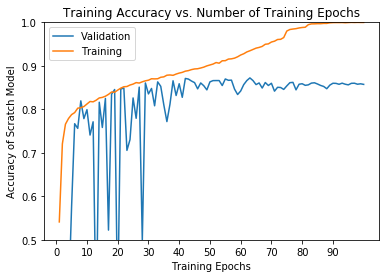

100


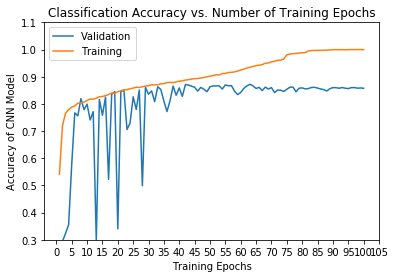

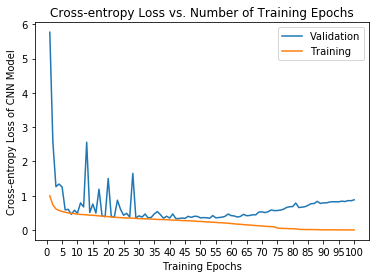

tensor([[2591.,   37.,   92.],
        [  59., 2002.,  386.],
        [ 115.,  359., 2563.]])
[2765. 2398. 3041.]
[[0.95257354 0.01360294 0.03382353]
 [0.02411116 0.8181447  0.15774417]
 [0.03786632 0.11820876 0.84392494]]


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "





Fold- 1 : Initializing Datasets and Dataloaders...
Gra train data: 10876
Lym train data: 9795
Mon train data: 12151
F:\WBCDataset_v4\2DProjectionsKFold-aug\Gra_Y\Fold-2
Gra Val data: 2714
Gra mini-train data: 2171
Gra mini-val data: 543
Lym Val data: 2447
Lym mini-train data: 1957
Lym mini-val data: 490
Mon Val data: 3039
Mon mini-train data: 2431
Mon mini-val data: 608
Epoch 0/99
----------
LR 5e-05
train: CE: 1.097122, MSE: 12687912.290171, loss: 1.224001
train Acc: 0.3702
train Bal. Acc: 0.3333
val: CE: 1.094818, MSE: 12641015.737073, loss: 1.221228
val Acc: 0.3706
val Bal. Acc: 0.3333
saving best model
Total time: 0:05:30.720320
Epoch time: 5m 31s
Epoch 1/99
----------
LR 5e-05
train: CE: 1.095031, MSE: 12687912.340381, loss: 1.221910
train Acc: 0.3702
train Bal. Acc: 0.3333
val: CE: 1.094707, MSE: 12641015.697561, loss: 1.221118
val Acc: 0.3706
val Bal. Acc: 0.3333
Total time: 0:11:01.675720
Epoch time: 5m 31s
Epoch 2/99
----------
LR 5e-05
train: CE: 1.094796, MSE: 12687912.35

val: CE: 0.474272, MSE: 141496.229977, loss: 0.475687
val Acc: 0.8307
val Bal. Acc: 0.8235
Total time: 2:20:04.065051
Epoch time: 5m 36s
Epoch 25/99
----------
LR 5e-05
train: CE: 0.345284, MSE: 134223.868883, loss: 0.346627
train Acc: 0.8592
train Bal. Acc: 0.8595
val: CE: 0.737628, MSE: 153769.884726, loss: 0.739166
val Acc: 0.6387
val Bal. Acc: 0.6556
Total time: 2:25:40.676092
Epoch time: 5m 37s
Epoch 26/99
----------
LR 5e-05
train: CE: 0.341547, MSE: 132746.042691, loss: 0.342874
train Acc: 0.8630
train Bal. Acc: 0.8632
val: CE: 0.420965, MSE: 121823.837104, loss: 0.422183
val Acc: 0.8294
val Bal. Acc: 0.8365
Total time: 2:31:16.850311
Epoch time: 5m 36s
Epoch 27/99
----------
LR 5e-05
train: CE: 0.335007, MSE: 124910.325169, loss: 0.336256
train Acc: 0.8662
train Bal. Acc: 0.8667
val: CE: 0.544189, MSE: 121352.837538, loss: 0.545402
val Acc: 0.8024
val Bal. Acc: 0.7920
Total time: 2:36:52.713385
Epoch time: 5m 36s
Epoch 28/99
----------
LR 5e-05
train: CE: 0.333732, MSE: 123153.

train: CE: 0.241547, MSE: 70674.193243, loss: 0.242253
train Acc: 0.9030
train Bal. Acc: 0.9035
val: CE: 0.440964, MSE: 80368.502614, loss: 0.441767
val Acc: 0.8391
val Bal. Acc: 0.8419
Total time: 5:12:01.096919
Epoch time: 5m 31s
Epoch 56/99
----------
LR 5e-05
train: CE: 0.236508, MSE: 72163.631398, loss: 0.237229
train Acc: 0.9062
train Bal. Acc: 0.9065
val: CE: 0.415674, MSE: 66004.458575, loss: 0.416334
val Acc: 0.8357
val Bal. Acc: 0.8314
Total time: 5:17:32.062919
Epoch time: 5m 31s
Epoch 57/99
----------
LR 5e-05
train: CE: 0.231732, MSE: 69481.596358, loss: 0.232426
train Acc: 0.9082
train Bal. Acc: 0.9088
val: CE: 0.375742, MSE: 66229.711650, loss: 0.376404
val Acc: 0.8563
val Bal. Acc: 0.8588
Total time: 5:23:03.466027
Epoch time: 5m 31s
Epoch 58/99
----------
LR 5e-05
train: CE: 0.228303, MSE: 69689.554663, loss: 0.229000
train Acc: 0.9089
train Bal. Acc: 0.9095
val: CE: 0.389823, MSE: 65460.240057, loss: 0.390478
val Acc: 0.8607
val Bal. Acc: 0.8602
Total time: 5:28:34.80

val: CE: 0.575550, MSE: 48087.280941, loss: 0.576031
val Acc: 0.8490
val Bal. Acc: 0.8479
Total time: 7:57:44.460038
Epoch time: 5m 32s
Epoch 86/99
----------
LR 1.25e-05
train: CE: 0.045055, MSE: 46264.938171, loss: 0.045518
train Acc: 0.9879
train Bal. Acc: 0.9881
val: CE: 0.586719, MSE: 47689.815156, loss: 0.587196
val Acc: 0.8521
val Bal. Acc: 0.8521
Total time: 8:03:17.320982
Epoch time: 5m 33s
Epoch 87/99
----------
LR 1.25e-05
train: CE: 0.042874, MSE: 46159.565292, loss: 0.043336
train Acc: 0.9893
train Bal. Acc: 0.9895
val: CE: 0.606406, MSE: 47846.082496, loss: 0.606885
val Acc: 0.8520
val Bal. Acc: 0.8505
Epoch    20: reducing learning rate of group 0 to 6.2500e-06.
Total time: 8:08:49.118251
Epoch time: 5m 32s
Epoch 88/99
----------
LR 6.25e-06
train: CE: 0.035049, MSE: 45190.948037, loss: 0.035501
train Acc: 0.9932
train Bal. Acc: 0.9933
val: CE: 0.593020, MSE: 45233.458712, loss: 0.593473
val Acc: 0.8518
val Bal. Acc: 0.8511
Total time: 8:14:20.959157
Epoch time: 5m 32s
E

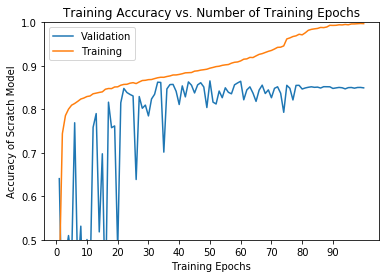

100


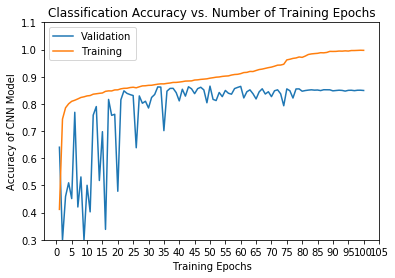

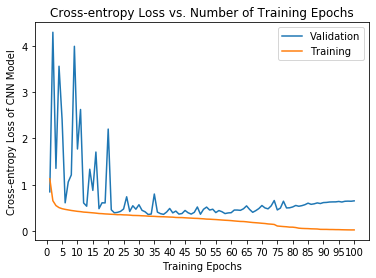

tensor([[2585.,   19.,  110.],
        [  86., 1900.,  461.],
        [ 106.,  322., 2611.]])
[2777. 2241. 3182.]
[[0.9524687  0.00700074 0.04053058]
 [0.03514507 0.77646095 0.18839395]
 [0.03487989 0.10595591 0.8591642 ]]


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "





Fold- 2 : Initializing Datasets and Dataloaders...
Gra train data: 10871
Lym train data: 9791
Mon train data: 12153
F:\WBCDataset_v4\2DProjectionsKFold-aug\Gra_Y\Fold-3
Gra Val data: 2719
Gra mini-train data: 2175
Gra mini-val data: 544
Lym Val data: 2451
Lym mini-train data: 1960
Lym mini-val data: 491
Mon Val data: 3037
Mon mini-train data: 2429
Mon mini-val data: 608
Epoch 0/99
----------
LR 5e-05
train: CE: 0.794455, MSE: 15817415.490995, loss: 0.952629
train Acc: 0.6378
train Bal. Acc: 0.6414
val: CE: 271.896160, MSE: 12745245.280614, loss: 272.023613
val Acc: 0.3313
val Bal. Acc: 0.3333
saving best model
Total time: 0:05:35.016425
Epoch time: 5m 35s
Epoch 1/99
----------
LR 5e-05
train: CE: 0.606276, MSE: 12661327.178851, loss: 0.732889
train Acc: 0.7504
train Bal. Acc: 0.7515
val: CE: 207.774736, MSE: 12745245.163153, loss: 207.902189
val Acc: 0.3313
val Bal. Acc: 0.3333
Total time: 0:11:08.737162
Epoch time: 5m 34s
Epoch 2/99
----------
LR 5e-05
train: CE: 0.545604, MSE: 126

val Bal. Acc: 0.8100
Total time: 1:53:32.781166
Epoch time: 5m 29s
Epoch 20/99
----------
LR 5e-05
train: CE: 0.370705, MSE: 82518.694367, loss: 0.371530
train Acc: 0.8520
train Bal. Acc: 0.8518
val: CE: 0.431576, MSE: 69026.172503, loss: 0.432267
val Acc: 0.8255
val Bal. Acc: 0.8232
Total time: 1:59:01.900803
Epoch time: 5m 29s
Epoch 21/99
----------
LR 5e-05
train: CE: 0.362706, MSE: 64890.155231, loss: 0.363354
train Acc: 0.8552
train Bal. Acc: 0.8548
val: CE: 0.390293, MSE: 58936.197195, loss: 0.390882
val Acc: 0.8420
val Bal. Acc: 0.8378
saving best model
Total time: 2:04:30.722051
Epoch time: 5m 29s
Epoch 22/99
----------
LR 5e-05
train: CE: 0.357323, MSE: 57413.738104, loss: 0.357897
train Acc: 0.8607
train Bal. Acc: 0.8602
val: CE: 0.992581, MSE: 51176.621073, loss: 0.993092
val Acc: 0.6304
val Bal. Acc: 0.6393
Total time: 2:09:59.386354
Epoch time: 5m 29s
Epoch 23/99
----------
LR 5e-05
train: CE: 0.351938, MSE: 48119.497505, loss: 0.352419
train Acc: 0.8582
train Bal. Acc: 0.

train Bal. Acc: 0.9168
val: CE: 0.470978, MSE: 8189.432421, loss: 0.471060
val Acc: 0.8205
val Bal. Acc: 0.8135
Total time: 4:43:35.879322
Epoch time: 5m 29s
Epoch 51/99
----------
LR 5e-05
train: CE: 0.200511, MSE: 8311.643153, loss: 0.200594
train Acc: 0.9206
train Bal. Acc: 0.9207
val: CE: 0.419328, MSE: 7709.654042, loss: 0.419405
val Acc: 0.8462
val Bal. Acc: 0.8472
Total time: 4:49:04.371642
Epoch time: 5m 28s
Epoch 52/99
----------
LR 5e-05
train: CE: 0.189231, MSE: 7942.618835, loss: 0.189310
train Acc: 0.9257
train Bal. Acc: 0.9257
val: CE: 0.436544, MSE: 7849.892771, loss: 0.436623
val Acc: 0.8531
val Bal. Acc: 0.8550
Total time: 4:54:33.461580
Epoch time: 5m 29s
Epoch 53/99
----------
LR 5e-05
train: CE: 0.178572, MSE: 7893.222963, loss: 0.178651
train Acc: 0.9285
train Bal. Acc: 0.9286
val: CE: 0.456907, MSE: 10029.501377, loss: 0.457007
val Acc: 0.8449
val Bal. Acc: 0.8516
Total time: 5:00:02.035398
Epoch time: 5m 29s
Epoch 54/99
----------
LR 5e-05
train: CE: 0.174718, MS

train Acc: 0.9981
train Bal. Acc: 0.9982
val: CE: 0.783493, MSE: 5904.895536, loss: 0.783552
val Acc: 0.8594
val Bal. Acc: 0.8562
Epoch    14: reducing learning rate of group 0 to 1.2500e-05.
Total time: 7:37:27.249130
Epoch time: 5m 29s
Epoch 82/99
----------
LR 1.25e-05
train: CE: 0.004547, MSE: 5790.070070, loss: 0.004605
train Acc: 0.9996
train Bal. Acc: 0.9996
val: CE: 0.772957, MSE: 5774.903915, loss: 0.773015
val Acc: 0.8617
val Bal. Acc: 0.8597
Total time: 7:42:55.985376
Epoch time: 5m 29s
Epoch 83/99
----------
LR 1.25e-05
train: CE: 0.002814, MSE: 5697.472495, loss: 0.002871
train Acc: 0.9999
train Bal. Acc: 0.9999
val: CE: 0.787935, MSE: 5716.144552, loss: 0.787993
val Acc: 0.8612
val Bal. Acc: 0.8590
Total time: 7:48:24.776726
Epoch time: 5m 29s
Epoch 84/99
----------
LR 1.25e-05
train: CE: 0.002653, MSE: 5656.923277, loss: 0.002710
train Acc: 0.9999
train Bal. Acc: 0.9999
val: CE: 0.803173, MSE: 5721.383215, loss: 0.803230
val Acc: 0.8611
val Bal. Acc: 0.8593
Total time: 7

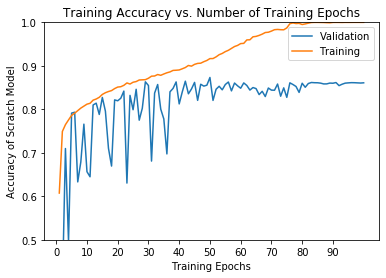

100


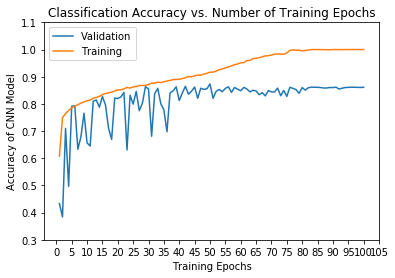

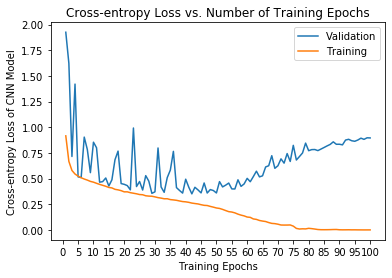

tensor([[2601.,   40.,   78.],
        [  75., 2116.,  260.],
        [ 104.,  483., 2450.]])
[2780. 2639. 2788.]
[[0.9566017  0.01471129 0.02868702]
 [0.03059975 0.86332107 0.10607915]
 [0.03424432 0.15903853 0.80671716]]


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "





Fold- 3 : Initializing Datasets and Dataloaders...
Gra train data: 10873
Lym train data: 9795
Mon train data: 12153
F:\WBCDataset_v4\2DProjectionsKFold-aug\Gra_Y\Fold-4
Gra Val data: 2717
Gra mini-train data: 2173
Gra mini-val data: 544
Lym Val data: 2447
Lym mini-train data: 1957
Lym mini-val data: 490
Mon Val data: 3037
Mon mini-train data: 2429
Mon mini-val data: 608
Epoch 0/99
----------
LR 5e-05
train: CE: 0.922540, MSE: 9079404.142957, loss: 1.013334
train Acc: 0.5264
train Bal. Acc: 0.5093
val: CE: 16.982406, MSE: 7102478.187721, loss: 17.053431
val Acc: 0.3313
val Bal. Acc: 0.3333
saving best model
Total time: 0:05:29.508862
Epoch time: 5m 30s
Epoch 1/99
----------
LR 5e-05
train: CE: 0.591283, MSE: 5517987.151062, loss: 0.646463
train Acc: 0.7546
train Bal. Acc: 0.7528
val: CE: 10.270912, MSE: 4656100.060298, loss: 10.317473
val Acc: 0.2934
val Bal. Acc: 0.3277
Total time: 0:10:58.929733
Epoch time: 5m 29s
Epoch 2/99
----------
LR 5e-05
train: CE: 0.535226, MSE: 3846894.987

Epoch 29/99
----------
LR 5e-05
train: CE: 0.334232, MSE: 21329.908946, loss: 0.334445
train Acc: 0.8691
train Bal. Acc: 0.8690
val: CE: 0.989132, MSE: 20459.579442, loss: 0.989337
val Acc: 0.6446
val Bal. Acc: 0.6448
Total time: 2:44:49.896647
Epoch time: 5m 33s
Epoch 30/99
----------
LR 5e-05
train: CE: 0.328655, MSE: 19701.719549, loss: 0.328852
train Acc: 0.8697
train Bal. Acc: 0.8694
val: CE: 3.908269, MSE: 19180.086212, loss: 3.908461
val Acc: 0.3353
val Bal. Acc: 0.3378
Total time: 2:50:21.785865
Epoch time: 5m 32s
Epoch 31/99
----------
LR 5e-05
train: CE: 0.327736, MSE: 18255.099101, loss: 0.327918
train Acc: 0.8696
train Bal. Acc: 0.8694
val: CE: 8.163446, MSE: 17510.239314, loss: 8.163621
val Acc: 0.2983
val Bal. Acc: 0.3332
Total time: 2:55:53.892860
Epoch time: 5m 32s
Epoch 32/99
----------
LR 5e-05
train: CE: 0.323873, MSE: 17185.139363, loss: 0.324045
train Acc: 0.8719
train Bal. Acc: 0.8718
val: CE: 2.718102, MSE: 16145.192891, loss: 2.718264
val Acc: 0.5751
val Bal. Ac

Total time: 5:30:47.499482
Epoch time: 5m 30s
Epoch 60/99
----------
LR 5e-05
train: CE: 0.201837, MSE: 9905.077932, loss: 0.201936
train Acc: 0.9209
train Bal. Acc: 0.9214
val: CE: 4.656328, MSE: 9625.416739, loss: 4.656424
val Acc: 0.3630
val Bal. Acc: 0.3622
Total time: 5:36:17.970194
Epoch time: 5m 30s
Epoch 61/99
----------
LR 5e-05
train: CE: 0.200297, MSE: 9860.315773, loss: 0.200396
train Acc: 0.9222
train Bal. Acc: 0.9227
val: CE: 14.762193, MSE: 10930.533169, loss: 14.762302
val Acc: 0.3313
val Bal. Acc: 0.3333
Total time: 5:41:47.732891
Epoch time: 5m 30s
Epoch 62/99
----------
LR 5e-05
train: CE: 0.193021, MSE: 9738.510257, loss: 0.193118
train Acc: 0.9249
train Bal. Acc: 0.9253
val: CE: 26.557985, MSE: 9592.143436, loss: 26.558081
val Acc: 0.2985
val Bal. Acc: 0.3334
Total time: 5:47:17.225415
Epoch time: 5m 29s
Epoch 63/99
----------
LR 5e-05
train: CE: 0.187094, MSE: 10050.938981, loss: 0.187194
train Acc: 0.9272
train Bal. Acc: 0.9276
val: CE: 3.597234, MSE: 9805.400014

Epoch time: 5m 33s
Epoch 90/99
----------
LR 6.25e-06
train: CE: 0.019510, MSE: 8242.492580, loss: 0.019592
train Acc: 0.9961
train Bal. Acc: 0.9962
val: CE: 1.136190, MSE: 8251.606545, loss: 1.136273
val Acc: 0.7643
val Bal. Acc: 0.7696
Total time: 8:22:01.821036
Epoch time: 5m 32s
Epoch 91/99
----------
LR 6.25e-06
train: CE: 0.017752, MSE: 8210.137743, loss: 0.017834
train Acc: 0.9967
train Bal. Acc: 0.9968
val: CE: 3.475069, MSE: 8214.608776, loss: 3.475152
val Acc: 0.5493
val Bal. Acc: 0.5393
Total time: 8:27:33.895026
Epoch time: 5m 32s
Epoch 92/99
----------
LR 6.25e-06
train: CE: 0.017653, MSE: 8195.655715, loss: 0.017735
train Acc: 0.9964
train Bal. Acc: 0.9964
val: CE: 1.314116, MSE: 8202.696037, loss: 1.314198
val Acc: 0.7761
val Bal. Acc: 0.7683
Total time: 8:33:06.372054
Epoch time: 5m 32s
Epoch 93/99
----------
LR 6.25e-06
train: CE: 0.016881, MSE: 8162.979142, loss: 0.016963
train Acc: 0.9966
train Bal. Acc: 0.9966
val: CE: 1.157033, MSE: 8187.093190, loss: 1.157115
val 

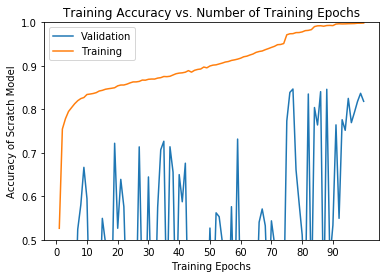

100


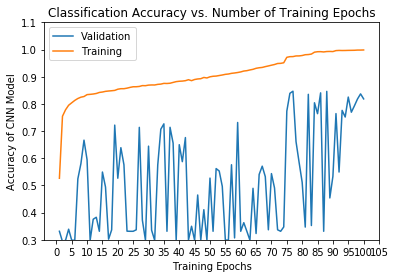

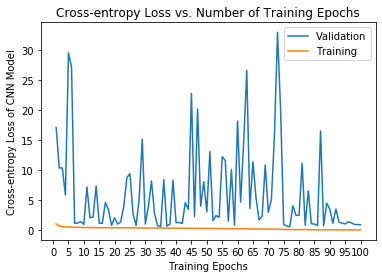

tensor([[2515.,   75.,  127.],
        [  64., 2115.,  268.],
        [ 103.,  620., 2314.]])
[2682. 2810. 2709.]
[[0.9256533  0.02760397 0.04674273]
 [0.02615448 0.8643237  0.10952187]
 [0.03391505 0.20414883 0.7619361 ]]


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "





Fold- 4 : Initializing Datasets and Dataloaders...
Gra train data: 10873
Lym train data: 9795
Mon train data: 12153
F:\WBCDataset_v4\2DProjectionsKFold-aug\Gra_Y\Fold-5
Gra Val data: 2717
Gra mini-train data: 2173
Gra mini-val data: 544
Lym Val data: 2447
Lym mini-train data: 1957
Lym mini-val data: 490
Mon Val data: 3037
Mon mini-train data: 2429
Mon mini-val data: 608
Epoch 0/99
----------
LR 5e-05
train: CE: 1.096450, MSE: 12710298.489565, loss: 1.223553
train Acc: 0.3703
train Bal. Acc: 0.3333
val: CE: 1.094757, MSE: 12552934.402146, loss: 1.220286
val Acc: 0.3703
val Bal. Acc: 0.3333
saving best model
Total time: 0:05:24.535104
Epoch time: 5m 25s
Epoch 1/99
----------
LR 5e-05
train: CE: 1.094861, MSE: 12710298.485665, loss: 1.221964
train Acc: 0.3703
train Bal. Acc: 0.3333
val: CE: 1.095068, MSE: 12552934.311791, loss: 1.220597
val Acc: 0.3703
val Bal. Acc: 0.3333
Total time: 0:10:49.021952
Epoch time: 5m 24s
Epoch 2/99
----------
LR 5e-05
train: CE: 1.094771, MSE: 12710298.46

train Bal. Acc: 0.8636
val: CE: 0.698242, MSE: 83994.145054, loss: 0.699082
val Acc: 0.7583
val Bal. Acc: 0.7585
Total time: 2:17:24.885428
Epoch time: 5m 30s
Epoch 25/99
----------
LR 5e-05
train: CE: 0.335950, MSE: 83537.517997, loss: 0.336785
train Acc: 0.8672
train Bal. Acc: 0.8670
val: CE: 0.821202, MSE: 84234.874986, loss: 0.822045
val Acc: 0.6694
val Bal. Acc: 0.6963
Total time: 2:22:55.634088
Epoch time: 5m 31s
Epoch 26/99
----------
LR 5e-05
train: CE: 0.335422, MSE: 77455.097471, loss: 0.336196
train Acc: 0.8650
train Bal. Acc: 0.8648
val: CE: 0.412666, MSE: 83954.673461, loss: 0.413506
val Acc: 0.8295
val Bal. Acc: 0.8188
Total time: 2:28:26.005706
Epoch time: 5m 30s
Epoch 27/99
----------
LR 5e-05
train: CE: 0.328011, MSE: 71482.883578, loss: 0.328725
train Acc: 0.8694
train Bal. Acc: 0.8693
val: CE: 0.471539, MSE: 85196.669846, loss: 0.472391
val Acc: 0.8075
val Bal. Acc: 0.8046
Total time: 2:33:56.490995
Epoch time: 5m 30s
Epoch 28/99
----------
LR 5e-05
train: CE: 0.3256

train: CE: 0.236641, MSE: 40591.692102, loss: 0.237047
train Acc: 0.9068
train Bal. Acc: 0.9072
val: CE: 0.431527, MSE: 40221.298268, loss: 0.431929
val Acc: 0.8389
val Bal. Acc: 0.8284
Total time: 5:08:02.566967
Epoch time: 5m 30s
Epoch 56/99
----------
LR 5e-05
train: CE: 0.234834, MSE: 39649.446755, loss: 0.235230
train Acc: 0.9083
train Bal. Acc: 0.9085
val: CE: 0.429441, MSE: 38196.030736, loss: 0.429823
val Acc: 0.8420
val Bal. Acc: 0.8328
Total time: 5:13:32.040159
Epoch time: 5m 29s
Epoch 57/99
----------
LR 5e-05
train: CE: 0.229645, MSE: 38634.024126, loss: 0.230031
train Acc: 0.9104
train Bal. Acc: 0.9108
val: CE: 0.433486, MSE: 35526.722351, loss: 0.433841
val Acc: 0.8533
val Bal. Acc: 0.8518
Total time: 5:19:02.402201
Epoch time: 5m 30s
Epoch 58/99
----------
LR 5e-05
train: CE: 0.224242, MSE: 39608.127190, loss: 0.224638
train Acc: 0.9120
train Bal. Acc: 0.9123
val: CE: 0.376350, MSE: 45316.068262, loss: 0.376803
val Acc: 0.8673
val Bal. Acc: 0.8702
Total time: 5:26:40.35

val: CE: 0.520021, MSE: 26752.456836, loss: 0.520288
val Acc: 0.8597
val Bal. Acc: 0.8629
Total time: 7:57:14.393966
Epoch time: 5m 29s
Epoch 86/99
----------
LR 1.25e-05
train: CE: 0.058578, MSE: 26965.767936, loss: 0.058848
train Acc: 0.9813
train Bal. Acc: 0.9815
val: CE: 0.557531, MSE: 27390.712659, loss: 0.557805
val Acc: 0.8550
val Bal. Acc: 0.8537
Total time: 8:02:43.940997
Epoch time: 5m 30s
Epoch 87/99
----------
LR 1.25e-05
train: CE: 0.057877, MSE: 27073.809183, loss: 0.058147
train Acc: 0.9823
train Bal. Acc: 0.9825
val: CE: 0.560471, MSE: 26797.468719, loss: 0.560739
val Acc: 0.8576
val Bal. Acc: 0.8568
Total time: 8:08:13.360936
Epoch time: 5m 29s
Epoch 88/99
----------
LR 1.25e-05
train: CE: 0.054393, MSE: 26943.328398, loss: 0.054662
train Acc: 0.9832
train Bal. Acc: 0.9834
val: CE: 0.567625, MSE: 27153.913135, loss: 0.567896
val Acc: 0.8586
val Bal. Acc: 0.8588
Total time: 8:13:43.258124
Epoch time: 5m 30s
Epoch 89/99
----------
LR 1.25e-05
train: CE: 0.051736, MSE: 26

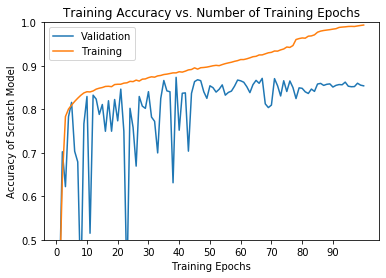

100


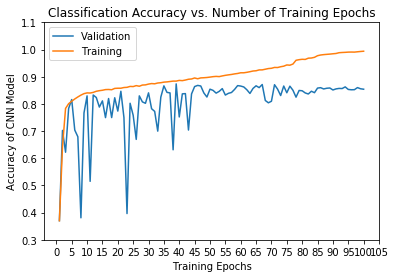

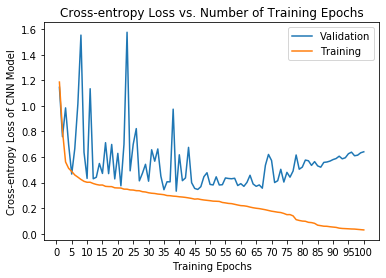

tensor([[2538.,   33.,  146.],
        [  66., 2028.,  353.],
        [  98.,  341., 2598.]])
[2702. 2402. 3097.]
[[0.9341185  0.01214575 0.05373574]
 [0.0269718  0.8287699  0.14425828]
 [0.03226868 0.11228186 0.85544944]]


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [17]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

for runs in range (0,5):
    print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
    #Kfold
    Fold = runs
    trainpath,testpath,minitrainpath,minitestpath= datapreparation(DatadirTrain,DatadirVal,Fold)
    image_datasets = {}
    image_datasets['train'] = MyDataset(trainpath)
    image_datasets['val'] = MyDataset(testpath)

    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_class = 3
    in_channel = 1
    num_epochs = 100
    loss_hist_train = []
    while (len(loss_hist_train)<num_epochs/2):
        model = UNet(num_class, in_channel)
        model.apply(init_weights)
        model = model.to(device)

        # freeze backbone layers
        # Comment out to finetune further
        # for l in model.base_layers:
        #     for param in l.parameters():
        #         param.requires_grad = False

        optimizer_ft1 = optim.Adam(model.parameters(), lr=5e-5,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        optimizer_ft2 = optim.Adam(model.parameters(), lr=5e-5,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        # optimizer_ft1 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # optimizer_ft2 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1) 
        exp_lr_scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)
        exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)       
        model, scratch_hist_train,loss_hist_train,scratch_hist_val, loss_hist_val,lr_hist,train_Bacc_hist,val_Bacc_hist = train_model(model, dataloaders_dict,optimizer_ft1, optimizer_ft2, exp_lr_scheduler1,exp_lr_scheduler2, num_epochs)
        if len(loss_hist_train)<num_epochs:
            print('model diverges, reinitializing training....\n')
            print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
        
    # num_epochs=15
    fname1 = "training_acc_"+str(runs)+".csv"
    np.savetxt(fname1,scratch_hist_train , delimiter=",")
    fname2 = "validation_acc_"+str(runs)+".csv"
    np.savetxt(fname2,scratch_hist_val , delimiter=",")
    fname13 = "training_Bacc_"+str(runs)+".csv"
    np.savetxt(fname13,train_Bacc_hist, delimiter=",")
    fname23 = "validation_Bacc_"+str(runs)+".csv"
    np.savetxt(fname23,val_Bacc_hist, delimiter=",")
    fname20 = "training_loss_"+str(runs)+".csv"
    np.savetxt(fname20,loss_hist_train , delimiter=",")
    fname21 = "validation_loss_"+str(runs)+".csv"
    np.savetxt(fname21,loss_hist_val , delimiter=",")
    fname22 = "learning_rate_"+str(runs)+".csv"
    np.savetxt(fname22,lr_hist , delimiter=",")
    
    shist = []
    shist1 = []

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Training Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of Scratch Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.5,1.))
    plt.xticks(np.arange(0, num_epochs, 10.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'.png'
    plt.savefig(fname3)
    plt.show()

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Classification Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of CNN Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.3,1.1))
    plt.xticks(np.arange(0, len(shist)+10, 5.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
    plt.savefig(fname3)
    plt.show()

    train_loss = [h for h in loss_hist_train]
    val_loss = [h for h in loss_hist_val]
    plt.title("Cross-entropy Loss vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Cross-entropy Loss of CNN Model")
    plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
    plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
    #     plt.ylim((0.5,1.05))
    plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
    plt.legend()
    fname31 = 'loss_curve_'+str(runs)+'.png'
    plt.savefig(fname31)
    plt.show()

    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
            inputs = inputs.type(torch.FloatTensor)
            inputs = inputs.to(device)
            classes = classes.to(device)
            _, outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    print(confusion_matrix)
    confusionMat = np.asarray(confusion_matrix)
    sumconfusion = np.sum(confusionMat,axis = 0)
    print(sumconfusion)

    import scipy
    sumconfusion = np.sum(confusionMat,axis = 1).T
    # print(np.tile(sumconfusion,(4,1)))
    summat = np.tile(sumconfusion,(3,1)).T
    # print(test)
    percentconfusion = np.divide(confusionMat,summat)
    print(percentconfusion)
    fname4 = "confusion_Mat_UNet_confusionMat_"+str(runs)+".csv"
    np.savetxt(fname4,confusionMat , delimiter=",")
    fname5 = "confusion_Mat_UNet_confusionPer_"+str(runs)+".csv"
    np.savetxt(fname5,percentconfusion , delimiter=",")
    fname6 = 'celltypemodel-unet_2D2D_Run_'+str(runs)+'.pth.tar'

    torch.save(model,fname6)
    print('\n\n')

In [ ]:
fname1 = "training_acc_"+str(runs)+".csv"
np.savetxt(fname1,scratch_hist_train , delimiter=",")
fname2 = "validation_acc_"+str(runs)+".csv"
np.savetxt(fname2,scratch_hist_val , delimiter=",")
fname13 = "training_Bacc_"+str(runs)+".csv"
np.savetxt(fname13,train_Bacc_hist, delimiter=",")
fname23 = "validation_Bacc_"+str(runs)+".csv"
np.savetxt(fname23,val_Bacc_hist, delimiter=",")
fname20 = "training_loss_"+str(runs)+".csv"
np.savetxt(fname20,loss_hist_train , delimiter=",")
fname21 = "validation_loss_"+str(runs)+".csv"
np.savetxt(fname21,loss_hist_val , delimiter=",")
fname22 = "learning_rate_"+str(runs)+".csv"
np.savetxt(fname22,lr_hist , delimiter=",")

shist = []
shist1 = []

shist = scratch_hist_val
shist1 = scratch_hist_train
print(len(shist))
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of Scratch Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.5,1.))
plt.xticks(np.arange(0, num_epochs, 10.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'.png'
plt.savefig(fname3)
plt.show()

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Classification Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of CNN Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.3,1.1))
plt.xticks(np.arange(0, len(shist)+10, 5.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
plt.savefig(fname3)
plt.show()

train_loss = [h for h in loss_hist_train]
val_loss = [h for h in loss_hist_val]
plt.title("Cross-entropy Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Cross-entropy Loss of CNN Model")
plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
#     plt.ylim((0.5,1.05))
plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
plt.legend()
fname31 = 'loss_curve_'+str(runs)+'.png'
plt.savefig(fname31)
plt.show()

confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        _, outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusionMat = np.asarray(confusion_matrix)
sumconfusion = np.sum(confusionMat,axis = 0)
print(sumconfusion)

import scipy
sumconfusion = np.sum(confusionMat,axis = 1).T
# print(np.tile(sumconfusion,(4,1)))
summat = np.tile(sumconfusion,(3,1)).T
# print(test)
percentconfusion = np.divide(confusionMat,summat)
print(percentconfusion)
fname4 = "confusion_Mat_ResNet_confusionMat_"+str(runs)+".csv"
np.savetxt(fname4,confusionMat , delimiter=",")
fname5 = "confusion_Mat_ResNet_confusionPer_"+str(runs)+".csv"
np.savetxt(fname5,percentconfusion , delimiter=",")
fname6 = 'celltypemodel-ResNet_3D_Run_'+str(runs)+'.pth.tar'

torch.save(model,fname6)
print('\n\n')

In [ ]:
import seaborn as sns
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 0),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
CellName = ['HEK293','HELA','MCF7']
categories = CellName
make_confusion_matrix(percentconfusion, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Blues',title = 'ResNet18 - 3D Input')

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model = torch.load('celltypemodel-resnet_80rech_Run_1.pth.tar')
scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[:-1]))
scratch_model_fc = scratch_model_fc.to(device)
scratch_model_fc.eval()

In [ ]:
#testing
image_datasets = {}
test_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
image_datasets['val'].__getitem__(0)[0].shape

In [ ]:
# Create training and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = scratch_model_fc(inputs).cpu().clone().numpy()
        if i == 0:
            outputlist = outputs
            y = classes.cpu().clone().numpy()
        else:
            outputlist = np.append(outputlist,outputs, axis=0)
            y = np.append(y,classes.cpu().clone().numpy(), axis=0)

In [ ]:
print(len(outputlist))
print(outputlist.shape)
print(y.shape)
outputlist = np.squeeze(outputlist)
print(outputlist.shape)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=45, learning_rate=200,early_exaggeration = 40, n_iter=4000)
X_2d = tsne.fit_transform(outputlist)
CellName = ['HEK293','HELA','MCF7']

In [ ]:

target_ids = range(len(outputlist))
plt.figure(figsize=(4,4))
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, CellName):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1],s=3, c=c, label=label,alpha=0.5)
plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('ResNet18 - 3D Input')
plt.show()